In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.vae import VAE, Initializer

import numpy as np
import os

%load_ext autoreload
%autoreload 2

In [2]:
TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vae-imagenet')
IMAGE_SZ = (64, 64)
NUM_WORKERS = 4
GIF_DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature'
IMG_DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/TinyImageNet'
IMG_BATCH_SZ = 128
GIF_BATCH_SZ = 64
TRANSFORMS = transforms.Compose([transforms.Resize(IMAGE_SZ), transforms.ToTensor()])
DISP_LIM = 8

In [3]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [4]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [5]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [6]:
MAX_FRAMES = 10

gif_train_set = TGIF(
    root=f'{GIF_DATASET_ROOT}/train',
    preload=False,
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS
)

gif_val_set = TGIF(
    root=f'{GIF_DATASET_ROOT}/val',
    preload=False,
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS,
)

gif_test_set = TGIF(
    root=f'{GIF_DATASET_ROOT}/test',
    preload=False,
    max_frames=MAX_FRAMES,
    transform=TRANSFORMS
)

print(len(gif_train_set), len(gif_val_set), len(gif_test_set))

3995 750 250


In [7]:
gif_train_loader = DataLoader(gif_train_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_val_loader = DataLoader(gif_val_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_test_loader = DataLoader(gif_val_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [11]:
img_train_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/train', transform=TRANSFORMS)
img_val_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/test', transform=TRANSFORMS)
img_test_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/val', transform=TRANSFORMS)

print(len(img_train_set), len(img_val_set), len(img_test_set))

100000 10000 10000


In [9]:
img_train_loader = DataLoader(img_train_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_val_loader = DataLoader(img_val_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_test_loader = DataLoader(img_val_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def gif_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

torch.Size([40, 3, 64, 64])


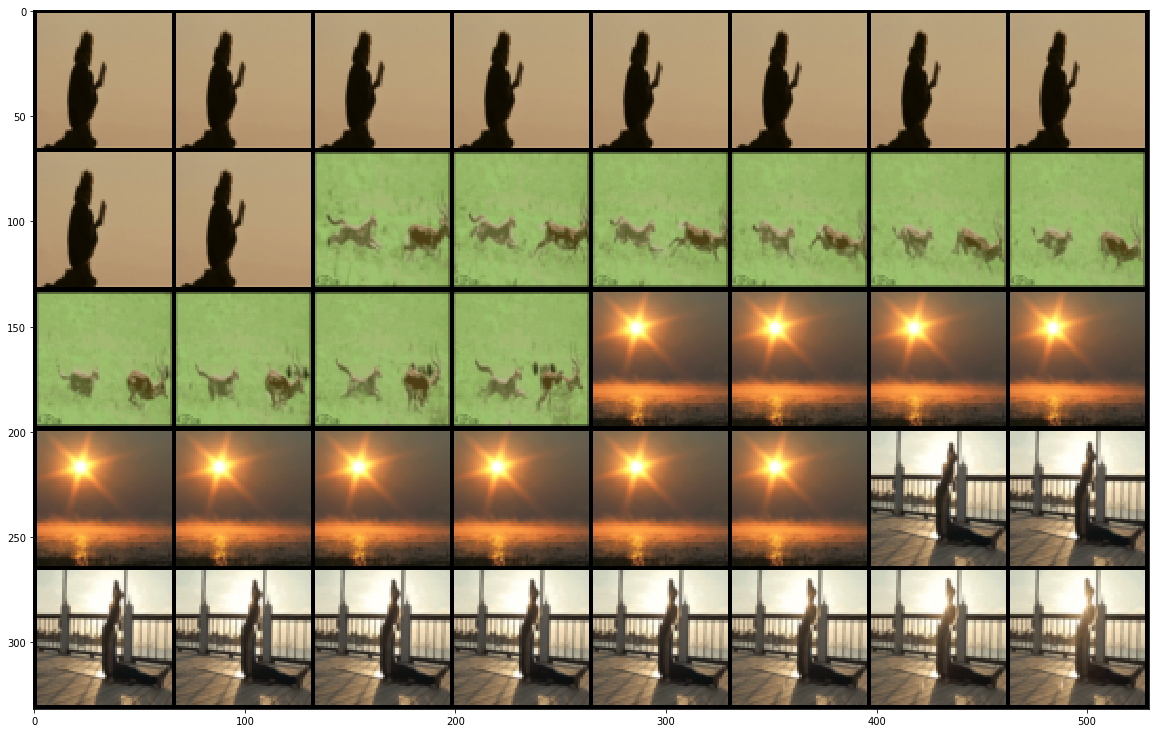

In [11]:
%matplotlib inline
gifs = []
for i, gif in enumerate(gif_train_loader):
    gifs.append(gif[0])
    if i == 3:
        break
gif = torch.cat(tuple(gifs), dim=0)
print (gif.shape)
gif_show(torchvision.utils.make_grid(gif))

torch.Size([128, 3, 64, 64])


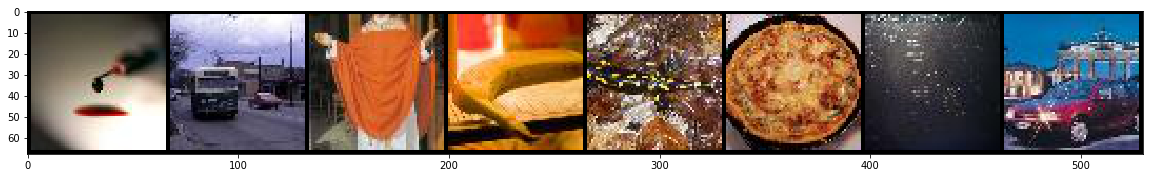

In [12]:
%matplotlib inline
img = iter(img_train_loader).next()[0]
print (img.shape)
gif_show(torchvision.utils.make_grid(img[:DISP_LIM]))

In [80]:
def train_fn(model, optimizer, inp, reg_rate=1e-12):
    def loss_fn(recon_x, x, mu, logvar):
        mse_loss = nn.L1Loss(size_average=False)
        MSE = mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + reg_rate*KLD
        
    model.train()
    x = inp[0]
    x = x.to(device=device, dtype=dtype)
    recon_x, mu, logvar = model(x)

    loss = loss_fn(recon_x, x, mu, logvar)
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [81]:
def validation_loss (model, val_loader): 
    def validation_loss_batch (model, inp):
        def loss_fn(recon_x, x, mu, logvar):
            mse_loss = nn.MSELoss(size_average=False)
            MSE = mse_loss(recon_x, x)
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            return MSE + KLD
            
        model.eval()
        x = inp[0]
        x = x.to(device=device, dtype=dtype)
        recon_x, mu, logvar = model(x)

        loss = loss_fn(recon_x, x, mu, logvar)
        return loss.item()

    loss = 0
    batch_count = 0
    for batch in val_loader:
        loss += validation_loss_batch (model, batch)
        batch_count += 1
    return loss / batch_count

In [82]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    return torch.stack(ret).transpose(0, 1)
    
def img_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    

In [83]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS

net = VAE(latent_size=100, device=device)
Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
optimizer = optim.Adam(net.parameters(), lr=1.5e-3)
trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)

In [84]:
try:
    print('Starting training (batch size )...')
#     optimizer = optim.Adam(net.parameters(), lr=1.5e-5)
#     trainer.update_optimizer(optimizer)
    trainer.train(img_train_loader, epochs=4, print_every=100, save_every=100)
except KeyboardInterrupt:
    print("Force saving")
    trainer.save_data(force_save=True)

Starting training (batch size )...
Epoch [0] (0/781), loss = 1660606.7500
Epoch [0] (100/781), loss = 495243.0312
Epoch [0] (200/781), loss = 333258.6250
Epoch [0] (300/781), loss = 244289.1719
Epoch [0] (400/781), loss = 223201.3750
Epoch [0] (500/781), loss = 204392.0938
Epoch [0] (600/781), loss = 195279.4531
Epoch [0] (700/781), loss = 191472.7656
Epoch [0] done
Epoch [1] (0/781), loss = 186430.4688
Epoch [1] (100/781), loss = 184316.2188
Epoch [1] (200/781), loss = 180878.7344
Epoch [1] (300/781), loss = 180621.4375
Epoch [1] (400/781), loss = 182285.3281
Epoch [1] (500/781), loss = 179961.5625
Epoch [1] (600/781), loss = 185034.5312
Epoch [1] (700/781), loss = 180882.0156
Epoch [1] done
Epoch [2] (0/781), loss = 179179.3750
Epoch [2] (100/781), loss = 162841.6562
Epoch [2] (200/781), loss = 173946.1719
Epoch [2] (300/781), loss = 173560.7500
Epoch [2] (400/781), loss = 178269.9062
Epoch [2] (500/781), loss = 166735.4531
Epoch [2] (600/781), loss = 169137.9375
Epoch [2] (700/781),

torch.Size([128, 3, 64, 64])


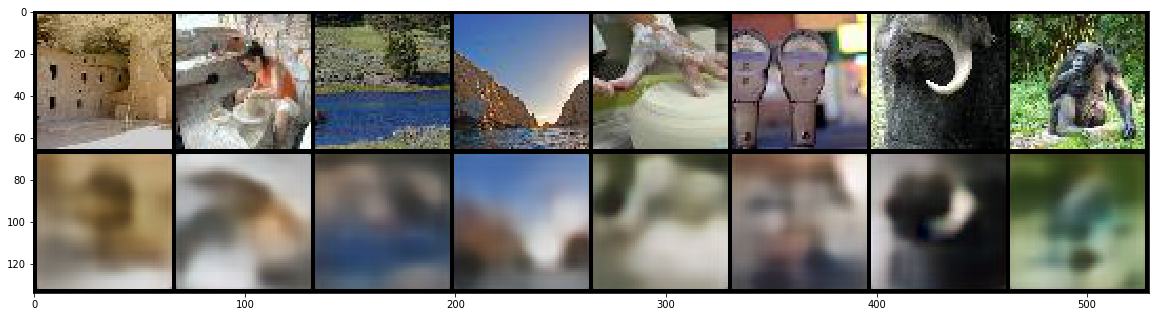

In [88]:
img_test_autoenc(net, img_train_loader)

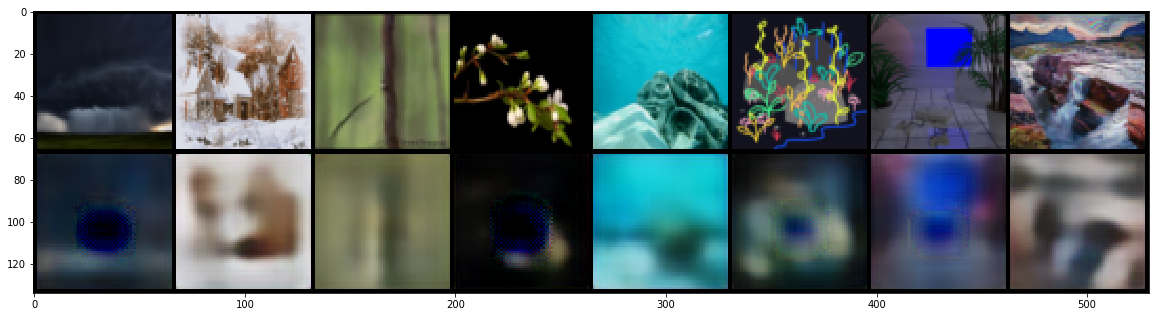

In [87]:
gif_test_autoenc(net, gif_val_loader)

In [20]:
TUNE_EPOCHS_COARSE = 4
TUNE_EPOCHS_FINE = 2
TUNE_FINE_N = 2
TUNE_COARSE_N = 200
TUNE_STATS_COARSE_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', f'vae-tune-imagenet-coarse')
TUNE_STATS_FINE_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', f'vae-tune-imagenet-fine')

def tune_hyperparams_fine(lr_base, latent_sz_base):
    best_lr = lr_base
    best_latent_sz = latent_sz_base
    best_loss = float('inf')

    tune_offsets_lr = [lr_base / 2, lr_base / 2, lr_base / 4, lr_base / 8, lr_base / 16, lr_base / 32]
    tune_offsets_latent_sz = [latent_sz_base / 2, latent_sz_base / 2, latent_sz_base / 4, latent_sz_base / 10, latent_sz_base / 20, latent_sz_base / 30]

    for lr_offset, latent_sz_offset in zip(tune_offsets_lr, tune_offsets_latent_sz):
        for i in range(TUNE_FINE_N):
            lr = max(best_lr + (np.random.rand() * 2 - 1) * lr_offset, 1e-10)
            latent_sz = max(best_latent_sz + int((np.random.rand() * 2 - 1) * latent_sz_offset), 20)
            
            print (f'  [FINE] [lr = {lr}, latent_sz = {latent_sz}] ', end="")
            
            net = VAE(latent_size=latent_sz, 
                      device=device)
            
            Initializer.initialize(model=net,
                                   initialization=init.xavier_uniform_,
                                   gain=init.calculate_gain('relu'))
            
            optimizer = optim.Adam(net.parameters(), 
                                   lr=lr)
            
            trainer = ModelTrainer(net, 
                                   optimizer, 
                                   train_fn, 
                                   TUNE_STATS_FINE_ROOT,
                                   tags=['vae-tune', 'fine'],
                                   save_models=False)

            trainer.train(img_train_loader, 
                          verbose=False,
                          epochs=TUNE_EPOCHS_FINE,
                          save_every=50)

            loss = validation_loss(net, img_val_loader)

            print (f'Validation loss: {loss}')

            if loss < best_loss:
                print (f'  [FINE]     [new best] Old best ({best_loss}) > new best ({loss})')
                best_lr = lr
                best_latent_sz = latent_sz
                best_loss = loss
                gif_test_autoenc(net, gif_val_loader)
            
    print (f'  [FINE] Done.')
    print ()
    print (f'  [FINE] Best learning rate = {all_best_lr}')
    print (f'  [FINE] Best latent size = {all_best_latent_sz}')
    return best_loss, best_lr, best_latent_sz
    
def tune_hyperparams_coarse(llr_lower, llr_upper, llatent_sz_lower, llatent_sz_upper):
    best_lr = None
    best_latent_sz = None
    best_loss = float('inf')

    for i in range(TUNE_COARSE_N):
        lr = 10 ** -np.random.uniform(llr_lower, llr_upper)
        latent_sz = 10 * np.random.randint(llatent_sz_lower, llatent_sz_upper)

        print (f'[COARSE] [lr = {lr}, latent_sz = {latent_sz}] ', end="")

        net = VAE(latent_size=latent_sz, 
                  device=device)

        Initializer.initialize(model=net,
                               initialization=init.xavier_uniform_,
                               gain=init.calculate_gain('relu'))

        optimizer = optim.Adam(net.parameters(), 
                               lr=lr)

        trainer = ModelTrainer(net, 
                               optimizer, 
                               train_fn, 
                               TUNE_STATS_COARSE_ROOT,
                               tags=['vae-tune', 'coarse'],
                               save_models=False)

        trainer.train(img_train_loader, 
                      verbose=False,
                      epochs=TUNE_EPOCHS_COARSE,
                      save_every=50)

        loss = validation_loss(net, img_val_loader)

        print (f'Validation loss: {loss}')

        if loss < best_loss:
            print (f'[COARSE]     [NEW BEST] Old best ({best_loss}) > new best ({loss})')
            best_lr = lr
            best_latent_sz = latent_sz
            best_loss = loss
            gif_test_autoenc(net, gif_val_loader)
            
    print (f'[COARSE] Done.')
    print ()
    print (f'[COARSE] Best learning rate = {best_lr}')
    print (f'[COARSE] Best latent size = {best_latent_sz}')
    return best_loss, best_lr, best_latent_sz

In [51]:
# %matplotlib inline
# best_loss_coarse, best_lr, best_latent_sz = tune_hyperparams_coarse (2, 6, 1, 200)
# # best_loss_fine, best_lr_fine, best_latent_sz_fine = tune_hyperparams_fine (best_lr_coarse, best_latent_sz_coarse)

# # best_lr, best_latent_sz = best_lr_coarse, best_latent_sz_coarse 
# #                           if best_loss_coarse < best_loss_fine 
# #                           else best_lr_fine, best_latent_sz_fine

BEST_MODEL_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', f'vae-tune-imagenet-best')

# net = VAE(latent_size=best_latent_sz, device=device)
# Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
# optimizer = optim.Adam(net.parameters(), lr=best_lr)
# trainer = ModelTrainer(net, optimizer, train_fn, BEST_MODEL_ROOT, tags=['vae-tune', 'best'], save_models=False)

# print ('Training best model...')
# trainer.train(img_train_loader, epochs=30, print_every=780, save_every=100)
# trainer.save_data(force_save=True)

In [72]:
# BEST_MODEL_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', f'vae-tune-imagenet-best')

# net = VAE(latent_size=best_latent_sz, device=device)
# Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
# optimizer = optim.Adam(net.parameters(), lr=best_lr)
# trainer = ModelTrainer(net, optimizer, train_fn, BEST_MODEL_ROOT, tags=['vae-tune', 'best'], save_models=False)

# print ('Training best model...')
# trainer.train(img_train_loader, epochs=30, print_every=780, save_every=100)
# trainer.save_data(force_save=True)

# trainer.load_model('1527944799.3859553')
def train_fn_l1(model, optimizer, inp):
    def loss_fn(recon_x, x, mu, logvar):
        p = 1
        l1_loss = nn.L1Loss(size_average=False)
        
        L1 = l1_loss(recon_x, x)


        
        GDL_1 = torch.abs(torch.abs(recon_x[:, :, :, :-1] - recon_x[:, :, :, 1:]) - torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) ** p
        GDL_2 = torch.abs(torch.abs(recon_x[:, :, :-1, :] - recon_x[:, :, 1:, :]) - torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])) ** p

        GDL =  (torch.sum(GDL_1) + torch.sum(GDL_2))/x.shape[0]
              
            
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return L1 + GDL + KLD
        
    model.train()
    x = inp[0]
    x = x.to(device=device, dtype=dtype)
    recon_x, mu, logvar = model(x)

    loss = loss_fn(recon_x, x, mu, logvar)
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


net = VAE(latent_size=950, device=device)
optimizer = optim.Adam(net.parameters(), lr=1.6e-3)


trainer = ModelTrainer(net, optimizer, train_fn_l1, TEST_MODEL_PATH, save_models=False, tags=['vae', 'l1', 'gdl'])


In [79]:
try:
    print('Starting training (batch size )...')
#     optimizer = optim.Adam(net.parameters(), lr=1.6e-5)
#     trainer.update_optimizer(optimizer)
    
    trainer.train(img_train_loader, epochs=4, print_every=100, save_every=100)
except KeyboardInterrupt:
    print("Force saving")
    trainer.save_data(force_save=True)

Starting training (batch size )...
Epoch [0] (0/781), loss = 160591.3281
Epoch [0] (100/781), loss = 162992.3594
Epoch [0] (200/781), loss = 170017.4688
Epoch [0] (300/781), loss = 164674.9844
Epoch [0] (400/781), loss = 163050.1406
Epoch [0] (500/781), loss = 154990.6562
Epoch [0] (600/781), loss = 164066.1250
Epoch [0] (700/781), loss = 165599.3906
Epoch [0] done
Epoch [1] (0/781), loss = 161663.0625
Epoch [1] (100/781), loss = 164158.1250
Epoch [1] (200/781), loss = 158963.8125
Epoch [1] (300/781), loss = 158845.8906
Epoch [1] (400/781), loss = 164096.6250
Epoch [1] (500/781), loss = 160366.9688
Epoch [1] (600/781), loss = 164261.2031
Epoch [1] (700/781), loss = 162837.2812
Epoch [1] done
Epoch [2] (0/781), loss = 158009.2656
Epoch [2] (100/781), loss = 164346.9219
Epoch [2] (200/781), loss = 155027.4531
Epoch [2] (300/781), loss = 151426.4688
Epoch [2] (400/781), loss = 161567.9844
Epoch [2] (500/781), loss = 159119.2500
Epoch [2] (600/781), loss = 155050.1250
Epoch [2] (700/781), 

torch.Size([128, 3, 64, 64])


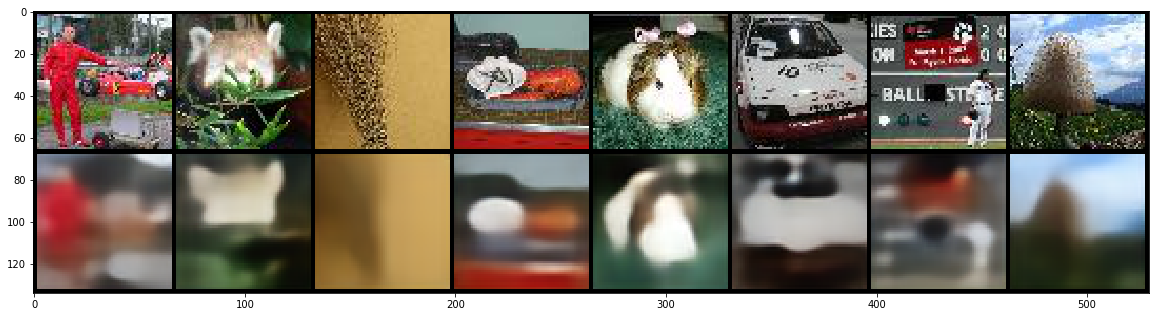

In [80]:
img_test_autoenc(net, img_train_loader)

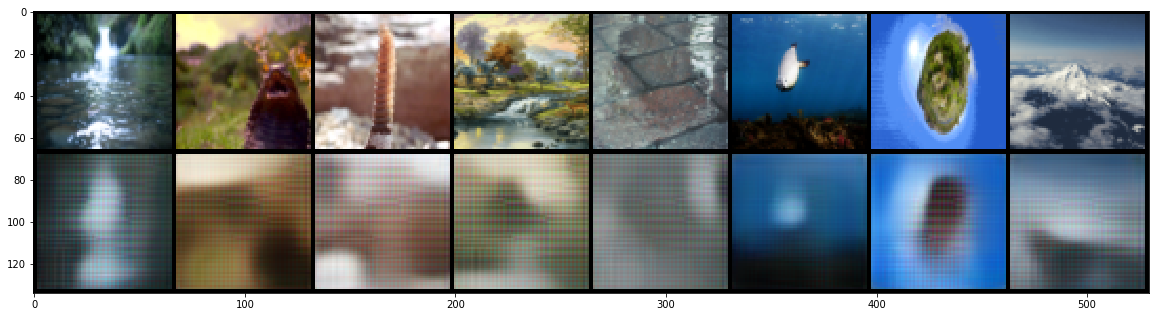

In [69]:
gif_test_autoenc(net, gif_val_loader)

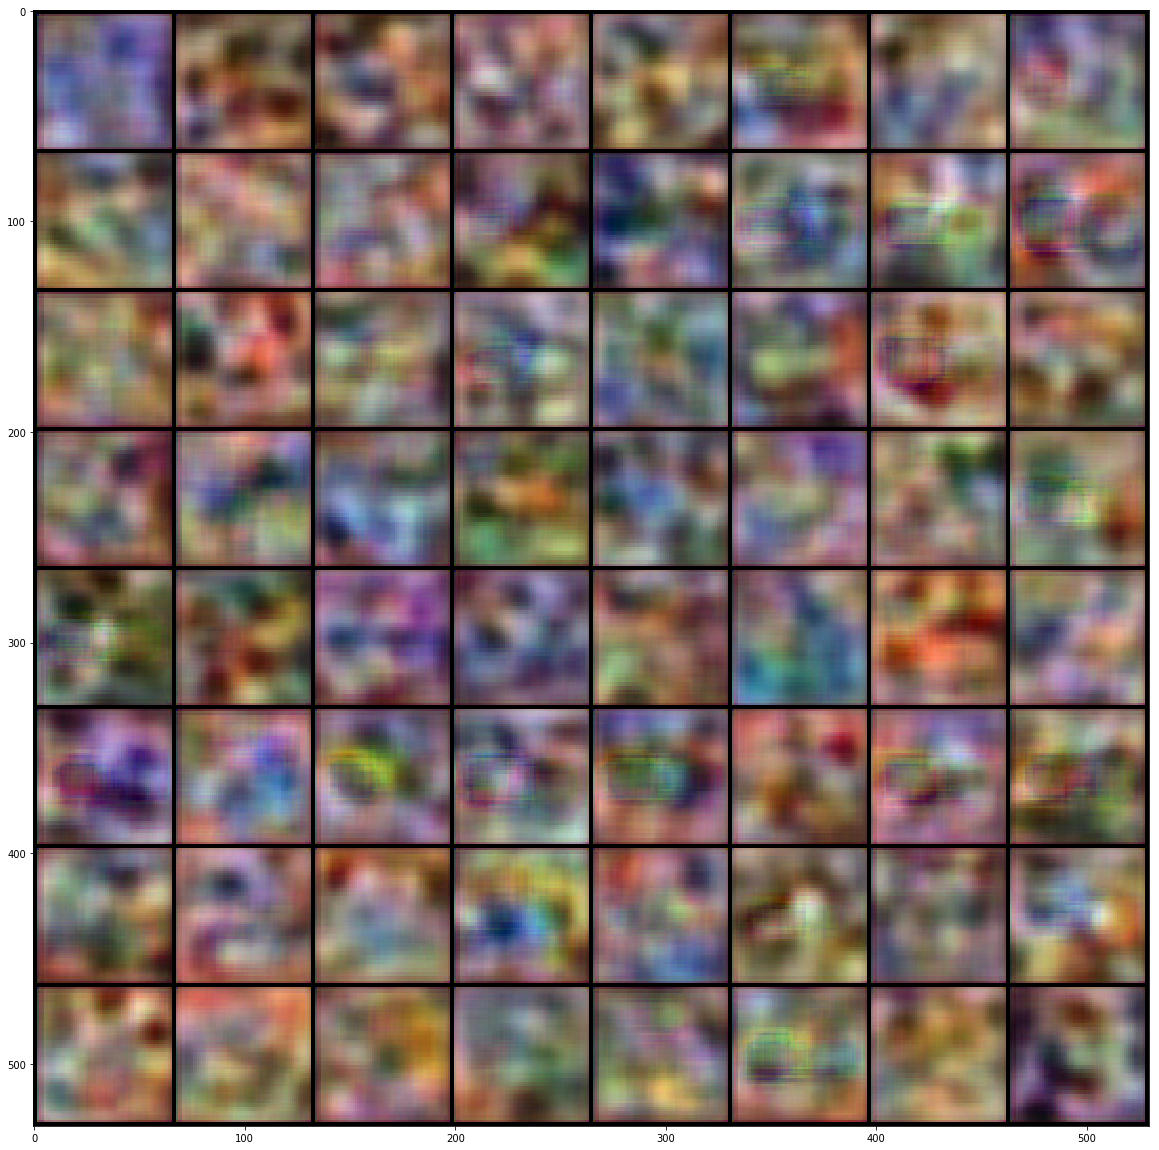

In [48]:
def vary_latent(init_z, step, length, dim, model, orig_img):
    print(init_z.shape)
    BATCH_IDX = 15
    BATCH_LIM = 5
    orig_img = orig_img.to(torch.device('cpu')).detach()

    ret = []
    curr_z = init_z.clone()
    curr_z = curr_z.to(device=device)
    
#     curr_z[dim] -= step*(length // 2)
    
    model.eval()
    for batch in range(BATCH_LIM):
        curr_z = init_z.clone()
        ret.append(orig_img[batch]) 
        for i in range(length):
            curr_z[:, dim] += step
            y = model.decoder(curr_z)
            y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
            ret.append(y[batch])
    
    gif_show(torchvision.utils.make_grid(torch.stack(ret)))
        
        
    

def get_latent_z(model, x):
    enc_y = model.encoder(x)
    mu, logvar = model.fc_mu(enc_y), model.fc_logvar(enc_y)
    return model.sample_latent(mu, logvar)


def sample_forward(model, z):
    return model.decoder(z)


def test_varying(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()    
#     x = x[0]
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)

    z = get_latent_z(net, x)
    print(z.shape)
    vary_latent(z, 1.0, 15, 0, net, x)
    
    
def gen_image(model):
    z = torch.randn((64, 100), device=device)
    y = model.decoder(z)
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    gif_show(torchvision.utils.make_grid(y))
    
# test_varying(net, gif_val_loader)

gen_image(net)